# 使用 MMEditing 进行抠图、图像修复和图像转译

MMEditing 包含图像编辑的若干子任务，在本教程中，我们将学习使用 MMEditing 完成抠图，图像修复和图像转译任务。

## 安装 MMEditing

In [1]:
# 检查 PyTorch 版本
!pip list | grep torch

torch                         1.8.1+cu101        
torchsummary                  1.5.1              
torchtext                     0.9.1              
torchvision                   0.9.1+cu101        


In [2]:
# 安装对应版本的 mmcv-full
!pip install mmcv-full -f https://download.openmmlab.com/mmcv/dist/cu101/torch1.8.0/index.html

Looking in links: https://download.openmmlab.com/mmcv/dist/cu101/torch1.8.0/index.html
     |████████████████████████████████| 31.2MB 91kB/s 
     |████████████████████████████████| 194kB 2.9MB/s 


In [3]:
# 源码安装 MMEditing
%cd /content
!rm -rf mmediting
!git clone https://github.com/open-mmlab/mmediting.git

%cd mmediting
!pip install -e .

/content
Cloning into 'mmediting'...
remote: Enumerating objects: 6640, done.
remote: Counting objects: 100% (845/845), done.
remote: Compressing objects: 100% (516/516), done.
remote: Total 6640 (delta 466), reused 577 (delta 317), pack-reused 5795
Receiving objects: 100% (6640/6640), 4.80 MiB | 15.80 MiB/s, done.
Resolving deltas: 100% (4465/4465), done.
/content/mmediting
Obtaining file:///content/mmediting
  Running setup.py develop for mmedit


In [4]:
# 检查PyTorchCheck Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Check MMEditing installation
import mmedit
print(mmedit.__version__)

1.8.1+cu101 True
0.7.0


## 抠图任务--使用预训练模型完成推理

### 查找并下载预训练模型

https://mmediting.readthedocs.io/en/latest/

In [5]:
# 下载 IndexNet 的预训练模型
!test -d checkpoints || mkdir checkpoints
!wget -c https://openmmlab.oss-accelerate.aliyuncs.com/mmediting/mattors/indexnet/indexnet_mobv2_1x16_78k_comp1k_SAD-45.6_20200618_173817-26dd258d.pth \
    -O checkpoints/indexnet_mobv2_1x16_78k_comp1k_SAD-45.6_20200618_173817-26dd258d.pth

--2021-05-28 09:11:01--  https://openmmlab.oss-accelerate.aliyuncs.com/mmediting/mattors/indexnet/indexnet_mobv2_1x16_78k_comp1k_SAD-45.6_20200618_173817-26dd258d.pth
Resolving openmmlab.oss-accelerate.aliyuncs.com (openmmlab.oss-accelerate.aliyuncs.com)... 47.75.20.25
Connecting to openmmlab.oss-accelerate.aliyuncs.com (openmmlab.oss-accelerate.aliyuncs.com)|47.75.20.25|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 24079143 (23M) [application/octet-stream]
Saving to: ‘checkpoints/indexnet_mobv2_1x16_78k_comp1k_SAD-45.6_20200618_173817-26dd258d.pth’

checkpoints/indexne 100%[===================>]  22.96M  14.3MB/s    in 1.6s    

2021-05-28 09:11:04 (14.3 MB/s) - ‘checkpoints/indexnet_mobv2_1x16_78k_comp1k_SAD-45.6_20200618_173817-26dd258d.pth’ saved [24079143/24079143]



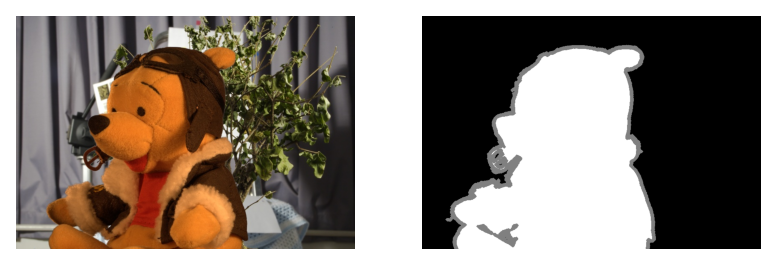

In [6]:
# 查看推理计算图像
%matplotlib inline 
import mmcv
from matplotlib import pyplot as plt

# Sample images path
merged_path = './tests/data/merged/GT05.jpg'
trimap_path = './tests/data/trimap/GT05.png'

# Plot sample images
merged = mmcv.imread(merged_path)
trimap = mmcv.imread(trimap_path)
f, axarr = plt.subplots(1, 2)
f.dpi = 160
axarr[0].axis('off')
axarr[0].imshow(mmcv.bgr2rgb(merged))
axarr[1].axis('off')
axarr[1].imshow(trimap)

### 调用 API 构建模型

In [7]:
from mmedit.apis import init_model

# Choose to use a config and initialize the mattor
config = './configs/mattors/indexnet/indexnet_mobv2_1x16_78k_comp1k.py'
# Setup a checkpoint file to load
checkpoint = './checkpoints/indexnet_mobv2_1x16_78k_comp1k_SAD-45.6_20200618_173817-26dd258d.pth'
# Initialize the recognizer
model = init_model(config, checkpoint, device='cuda:0')

Use load_from_local loader


In [8]:
model

IndexNet(
  (backbone): SimpleEncoderDecoder(
    (encoder): IndexNetEncoder(
      (layers): ModuleList(
        (0): ConvModule(
          (conv): Conv2d(4, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (activate): ReLU6(inplace=True)
        )
        (1): Sequential(
          (0): InvertedResidual(
            (conv): DepthwiseSeparableConvModule(
              (depthwise_conv): ConvModule(
                (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), groups=32, bias=False)
                (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                (activate): ReLU6(inplace=True)
              )
              (pointwise_conv): ConvModule(
                (conv): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
                (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track

### 调用 API 进行推理

In [9]:
from mmedit.apis import matting_inference

pred_alpha = matting_inference(model, merged_path, trimap_path) * 255

In [10]:
pred_alpha

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

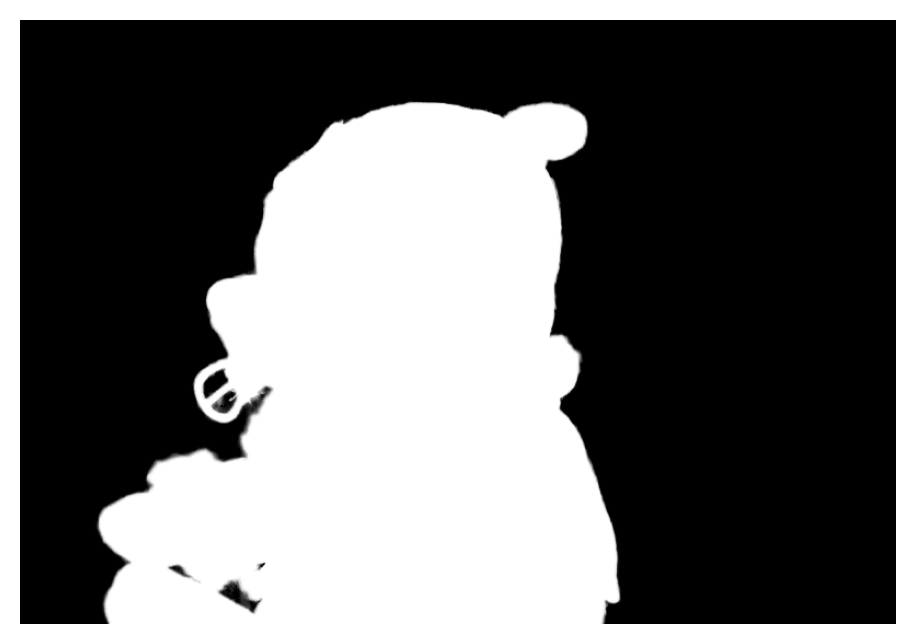

In [11]:
# 展示结果
plt.gcf().dpi = 200
plt.axis('off')
plt.imshow(pred_alpha, cmap=plt.get_cmap('gray'))
plt.show()

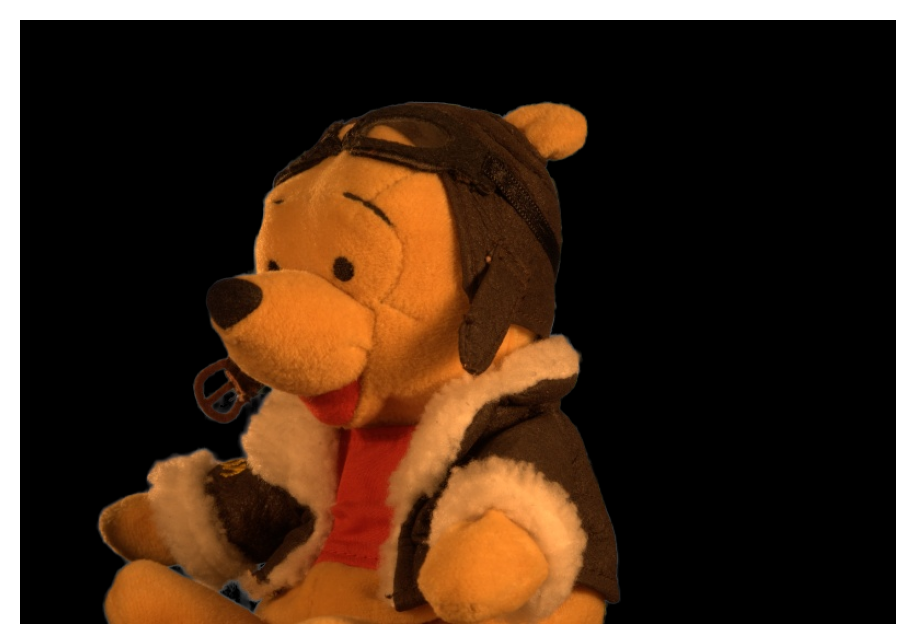

In [12]:
import mmcv
import numpy as np
import matplotlib.pyplot as plt

img = mmcv.imread(merged_path, channel_order='rgb')
foreground = pred_alpha[:,:,np.newaxis] / 255 * img / 255

plt.gcf().dpi = 200
plt.axis('off')
plt.imshow(foreground)
plt.show()

## 图像修复--使用预训练模型完成推理

### 查找并下载预训练模型

https://mmediting.readthedocs.io/en/latest/

In [13]:
# 下载 DeepFillv2 的预训练模型
!test -d checkpoint || mkdir checkpoint
!wget -c https://download.openmmlab.com/mmediting/inpainting/deepfillv2/deepfillv2_256x256_8x2_celeba_20200619-c96e5f12.pth \
      -O ./checkpoint/deepfillv2_256x256_8x2_celeba_20200619-c96e5f12.pth

--2021-05-28 09:11:21--  https://download.openmmlab.com/mmediting/inpainting/deepfillv2/deepfillv2_256x256_8x2_celeba_20200619-c96e5f12.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 47.88.36.78
Connecting to download.openmmlab.com (download.openmmlab.com)|47.88.36.78|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 41573447 (40M) [application/octet-stream]
Saving to: ‘./checkpoint/deepfillv2_256x256_8x2_celeba_20200619-c96e5f12.pth’

./checkpoint/deepfi 100%[===================>]  39.65M  11.6MB/s    in 4.4s    

2021-05-28 09:11:27 (8.94 MB/s) - ‘./checkpoint/deepfillv2_256x256_8x2_celeba_20200619-c96e5f12.pth’ saved [41573447/41573447]



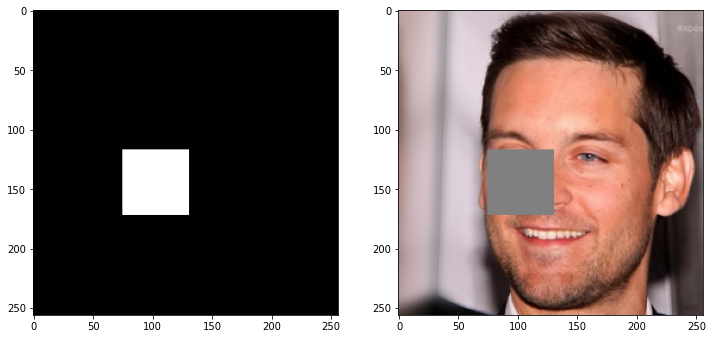

In [14]:
import mmcv
from matplotlib import pyplot as plt

# Sample images path
bbox_mask = './tests/data/image/bbox_mask.png'
celeba_test = './tests/data/image/celeba_test.png'

# Plot sample images
mask = mmcv.imread(bbox_mask)
img = mmcv.imread(celeba_test, channel_order='rgb')
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.imshow(mask)
plt.subplot(1,2,2)
plt.imshow(img)
plt.show()

### 调用 API 构建模型

In [15]:
from mmedit.apis import init_model

config_file = 'configs/inpainting/deepfillv2/deepfillv2_256x256_8x2_celeba.py'
checkpoint_file = 'checkpoint/deepfillv2_256x256_8x2_celeba_20200619-c96e5f12.pth'

model = init_model(config_file, checkpoint_file, device='cuda:0')

Use load_from_local loader


In [16]:
model

TwoStageInpaintor(
  (generator): DeepFillEncoderDecoder(
    (stage1): GLEncoderDecoder(
      (encoder): DeepFillEncoder(
        (enc1): SimpleGatedConvModule(
          (conv): ConvModule(
            (padding_layer): ReflectionPad2d((2, 2, 2, 2))
            (conv): Conv2d(5, 48, kernel_size=(5, 5), stride=(1, 1))
          )
          (feat_act): ELU(alpha=1.0)
          (gate_act): Sigmoid()
        )
        (enc2): SimpleGatedConvModule(
          (conv): ConvModule(
            (padding_layer): ReflectionPad2d((1, 1, 1, 1))
            (conv): Conv2d(24, 96, kernel_size=(3, 3), stride=(2, 2))
          )
          (feat_act): ELU(alpha=1.0)
          (gate_act): Sigmoid()
        )
        (enc3): SimpleGatedConvModule(
          (conv): ConvModule(
            (padding_layer): ReflectionPad2d((1, 1, 1, 1))
            (conv): Conv2d(48, 96, kernel_size=(3, 3), stride=(1, 1))
          )
          (feat_act): ELU(alpha=1.0)
          (gate_act): Sigmoid()
        )
        (e

### 调用 API 进行推理

In [17]:
from mmedit.apis import inpainting_inference

result = inpainting_inference(model, celeba_test, bbox_mask)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3503: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


In [18]:
result

tensor([[[[ 0.2078,  0.2235,  0.2314,  ...,  0.2078,  0.2314,  0.2627],
          [ 0.2078,  0.2235,  0.2314,  ...,  0.2078,  0.2314,  0.2627],
          [ 0.2078,  0.2235,  0.2314,  ...,  0.2000,  0.2235,  0.2549],
          ...,
          [-0.4745, -0.4902, -0.5059,  ..., -0.5294, -0.5373, -0.5451],
          [-0.5216, -0.5373, -0.5529,  ..., -0.5373, -0.5451, -0.5451],
          [-0.5529, -0.5686, -0.5843,  ..., -0.5373, -0.5451, -0.5529]],

         [[ 0.2471,  0.2549,  0.2627,  ...,  0.2000,  0.2235,  0.2627],
          [ 0.2471,  0.2549,  0.2627,  ...,  0.2000,  0.2235,  0.2549],
          [ 0.2471,  0.2549,  0.2627,  ...,  0.1922,  0.2157,  0.2471],
          ...,
          [-0.4431, -0.4588, -0.4745,  ..., -0.5294, -0.5451, -0.5451],
          [-0.4824, -0.4980, -0.5137,  ..., -0.5373, -0.5451, -0.5529],
          [-0.5137, -0.5294, -0.5451,  ..., -0.5451, -0.5451, -0.5529]],

         [[ 0.4667,  0.4745,  0.4745,  ...,  0.3255,  0.3490,  0.3804],
          [ 0.4667,  0.4745,  

#### 将 Pytorch Tensor 转换成图像

In [19]:
from mmedit.core import tensor2img
result_img = tensor2img(result, min_max=(-1, 1))

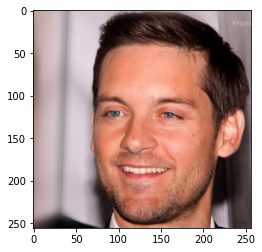

In [20]:
import numpy as np
plt.imshow(np.uint8(result_img))

## 图像转译--使用预训练模型完成推理

### 查找并下载预训练模型

https://mmediting.readthedocs.io/en/latest/

In [21]:
# 下载 CycleGAN 的预训练模型
!test -d checkpoint || mkdir checkpoint
!wget -c https://download.openmmlab.com/mmediting/synthesizers/cyclegan/cyclegan_horse2zebra/cyclegan_lsgan_resnet_in_1x1_266800_horse2zebra_20200524-1b3d5d3a.pth \
      -O ./checkpoint/cyclegan_lsgan_resnet_in_1x1_266800_horse2zebra_20200524-1b3d5d3a.pth

--2021-05-28 09:11:28--  https://download.openmmlab.com/mmediting/synthesizers/cyclegan/cyclegan_horse2zebra/cyclegan_lsgan_resnet_in_1x1_266800_horse2zebra_20200524-1b3d5d3a.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 47.75.20.25
Connecting to download.openmmlab.com (download.openmmlab.com)|47.75.20.25|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 113167701 (108M) [application/octet-stream]
Saving to: ‘./checkpoint/cyclegan_lsgan_resnet_in_1x1_266800_horse2zebra_20200524-1b3d5d3a.pth’

./checkpoint/cycleg 100%[===================>] 107.92M  14.9MB/s    in 7.5s    

2021-05-28 09:11:37 (14.5 MB/s) - ‘./checkpoint/cyclegan_lsgan_resnet_in_1x1_266800_horse2zebra_20200524-1b3d5d3a.pth’ saved [113167701/113167701]



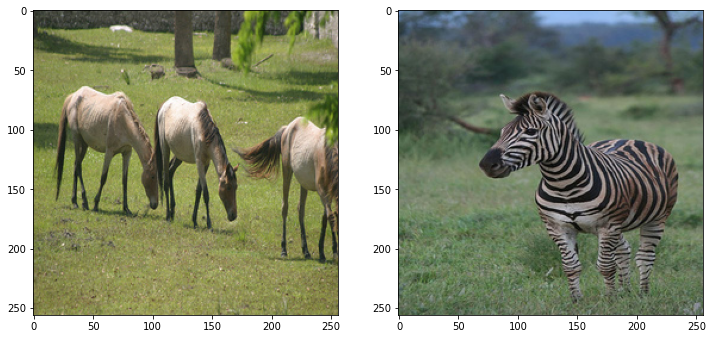

In [22]:
# 查看推理计算图像
import matplotlib.pyplot as plt
import mmcv

img = mmcv.imread('./tests/data/unpaired/testA/5.jpg', channel_order='rgb')
unpaired_img = mmcv.imread('./tests/data/unpaired/testB/6.jpg', channel_order='rgb')

plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.imshow(img)
plt.subplot(1,2,2)
plt.imshow(unpaired_img)
plt.show()

### 调用 API 构建模型

In [23]:
from mmedit.apis import init_model

config_file = './configs/synthesizers/cyclegan/cyclegan_lsgan_resnet_in_1x1_266800_horse2zebra.py'
checkpoint_file = './checkpoint/cyclegan_lsgan_resnet_in_1x1_266800_horse2zebra_20200524-1b3d5d3a.pth'

model = init_model(config_file, checkpoint_file, device='cuda:0')

/usr/local/lib/python3.7/dist-packages/mmcv/cnn/bricks/conv_module.py:107: UserWarning: ConvModule has norm and bias at the same time
  warnings.warn('ConvModule has norm and bias at the same time')


Use load_from_local loader


### 调用 API 进行推理

In [24]:
from mmedit.apis import generation_inference

output = generation_inference(model, './tests/data/unpaired/testA/5.jpg', './tests/data/unpaired/testB/6.jpg')

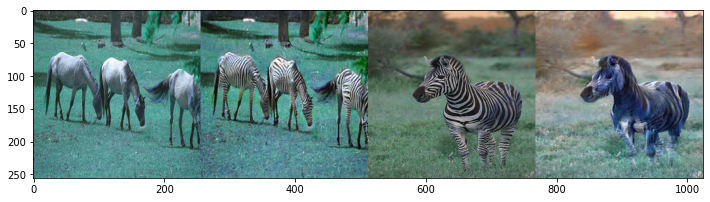

In [25]:
import numpy as np
plt.figure(figsize=(12,8))
plt.imshow(np.uint8(output))
plt.show()

## 图像转译--使用自定义数据集完成模型训练

使用 MMEditing 完成模型训练，我们需要三个步骤：

1. 准备训练数据
1. 修改配置文件
1. 启动训练

### 准备训练数据

使用 MMEditing 训练图像转译模型，我们需要将数据整理成如下格式：

1. 将不同的图像放置在不同的文件夹中。
1. 例如实力数据集中，将马的图像和斑马的图像分别整理到对应的文件夹中，马在 trainA/testA, 斑马在 trainB/testB 中。



In [26]:
# 下载数据集
!wget https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/horse2zebra.zip -O horse2zebra.zip
!mkdir data
!unzip -q horse2zebra.zip -d ./data/

--2021-05-28 09:11:39--  https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/horse2zebra.zip
Resolving people.eecs.berkeley.edu (people.eecs.berkeley.edu)... 128.32.244.190
Connecting to people.eecs.berkeley.edu (people.eecs.berkeley.edu)|128.32.244.190|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 116867962 (111M) [application/zip]
Saving to: ‘horse2zebra.zip’

horse2zebra.zip     100%[===================>] 111.45M  3.93MB/s    in 45s     

2021-05-28 09:12:25 (2.45 MB/s) - ‘horse2zebra.zip’ saved [116867962/116867962]



### 对应修改配置文件

In [27]:
config_path = "configs/synthesizers/cyclegan/cyclegan_lsgan_id0_resnet_in_1x1_266800_horse2zebra.py"

# 加载原始cyclegan的配置文件

from mmcv import Config

cfg = Config.fromfile(config_path)

print(f'Config:\n{cfg.pretty_text}')

Config:
model = dict(
    type='CycleGAN',
    generator=dict(
        type='ResnetGenerator',
        in_channels=3,
        out_channels=3,
        base_channels=64,
        norm_cfg=dict(type='IN'),
        use_dropout=False,
        num_blocks=9,
        padding_mode='reflect',
        init_cfg=dict(type='normal', gain=0.02)),
    discriminator=dict(
        type='PatchDiscriminator',
        in_channels=3,
        base_channels=64,
        num_conv=3,
        norm_cfg=dict(type='IN'),
        init_cfg=dict(type='normal', gain=0.02)),
    gan_loss=dict(
        type='GANLoss',
        gan_type='lsgan',
        real_label_val=1.0,
        fake_label_val=0.0,
        loss_weight=1.0),
    cycle_loss=dict(type='L1Loss', loss_weight=10.0, reduction='mean'),
    id_loss=dict(type='L1Loss', loss_weight=0, reduction='mean'))
train_cfg = dict(direction='a2b', buffer_size=50)
test_cfg = dict(direction='a2b', show_input=True)
train_dataset_type = 'GenerationUnpairedDataset'
val_dataset_type 

根据数据集位置配置路径

In [28]:
from mmcv.runner import set_random_seed

cfg.data_root  = './data/horse2zebra'
cfg.data.train.dataroot = './data/horse2zebra'
cfg.data.val.dataroot = './data/horse2zebra'
cfg.data.test.dataroot = './data/horse2zebra'

# 调整线程数
cfg.data.workers_per_gpu=1

# 调整训练周期
cfg.total_iters = 200
cfg.lr_config.start = 0
cfg.lr_config.interval = 100

# 随机种子
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpus = 1
print(f'Config:\n{cfg.pretty_text}')

Config:
model = dict(
    type='CycleGAN',
    generator=dict(
        type='ResnetGenerator',
        in_channels=3,
        out_channels=3,
        base_channels=64,
        norm_cfg=dict(type='IN'),
        use_dropout=False,
        num_blocks=9,
        padding_mode='reflect',
        init_cfg=dict(type='normal', gain=0.02)),
    discriminator=dict(
        type='PatchDiscriminator',
        in_channels=3,
        base_channels=64,
        num_conv=3,
        norm_cfg=dict(type='IN'),
        init_cfg=dict(type='normal', gain=0.02)),
    gan_loss=dict(
        type='GANLoss',
        gan_type='lsgan',
        real_label_val=1.0,
        fake_label_val=0.0,
        loss_weight=1.0),
    cycle_loss=dict(type='L1Loss', loss_weight=10.0, reduction='mean'),
    id_loss=dict(type='L1Loss', loss_weight=0, reduction='mean'))
train_cfg = dict(direction='a2b', buffer_size=50)
test_cfg = dict(direction='a2b', show_input=True)
train_dataset_type = 'GenerationUnpairedDataset'
val_dataset_type 

### 启动训练

调用对应的 Python API 启动训练

In [29]:
import os.path as osp

from mmedit.datasets import build_dataset
from mmedit.models import build_model
from mmedit.apis import train_model
from mmcv.runner import init_dist
import mmedit

import mmcv
import os

# 构建数据集
datasets = [build_dataset(cfg.data.train)]

# 构建模型
model = build_model(cfg.model, train_cfg=cfg.train_cfg, test_cfg=cfg.test_cfg)

# 创建工作路径
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))

# 额外信息
meta = dict()
if cfg.get('exp_name', None) is None:
    cfg['exp_name'] = osp.splitext(osp.basename(cfg.work_dir))[0]
meta['exp_name'] = cfg.exp_name
meta['mmedit Version'] = mmedit.__version__
meta['seed'] = 0

# 启动训练
train_model(model, datasets, cfg, distributed=False, validate=True, meta=meta)

/usr/local/lib/python3.7/dist-packages/mmcv/cnn/bricks/conv_module.py:107: UserWarning: ConvModule has norm and bias at the same time
  warnings.warn('ConvModule has norm and bias at the same time')
2021-05-28 09:12:29,378 - mmedit - INFO - Start running, host: root@06bcc3204441, work_dir: /content/mmediting/work_dirs/cyclegan_horse2zebra_id0
2021-05-28 09:12:29,380 - mmedit - INFO - workflow: [('train', 1)], max: 200 iters
2021-05-28 09:14:11,767 - mmedit - INFO - Iter [100/200]	lr_generators: 2.000e-04 lr_discriminators: 2.000e-04, eta: 0:01:42, time: 1.023, data_time: 0.002, memory: 2001, loss_gan_d_a: 0.8151, loss_gan_d_b: 0.7656, loss_gan_g_a: 0.9115, loss_gan_g_b: 0.8927, loss_cycle_a: 3.6644, loss_cycle_b: 3.9111
2021-05-28 09:15:54,956 - mmedit - INFO - Saving checkpoint at 200 iterations
2021-05-28 09:15:55,925 - mmedit - INFO - Iter [200/200]	lr_generators: 1.000e-04 lr_discriminators: 1.000e-04, eta: 0:00:00, time: 1.032, data_time: 0.002, memory: 2001, loss_gan_d_a: 0.2966,

### 使用完成训练之后的模型完成推理

模型训练会将模型权重存储在工作目录下，接着我们看一下训练后模型的效果。

/usr/local/lib/python3.7/dist-packages/mmcv/cnn/bricks/conv_module.py:107: UserWarning: ConvModule has norm and bias at the same time
  warnings.warn('ConvModule has norm and bias at the same time')


Use load_from_local loader


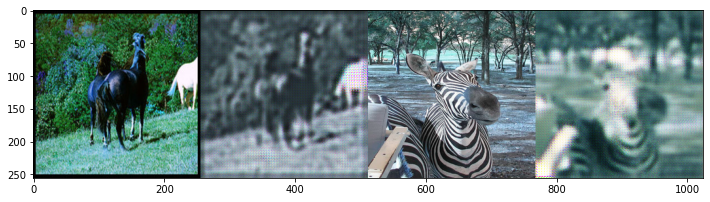

In [30]:
from mmedit.apis import init_model
from mmedit.apis import generation_inference

model = init_model(config_file, F'{cfg.work_dir}/latest.pth', device='cuda:0')
result = generation_inference(model, 'data/horse2zebra/testA/n02381460_1000.jpg', 'data/horse2zebra/testB/n02391049_1000.jpg')

plt.figure(figsize=(12,8))
plt.imshow(np.uint8(result))
plt.show()